In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt
import numpy as np

# Composable Networks
This tutorial demonstrates how to compose multiple networks and link them together to build a tree structure. A network tree is constructed by adding a child network to a parent network. After all networks are linked together, the entire network tree can be run by just running the root network.

The diagram below shows a network tree structure composed of three subnetworks that will be created in this tutorial.
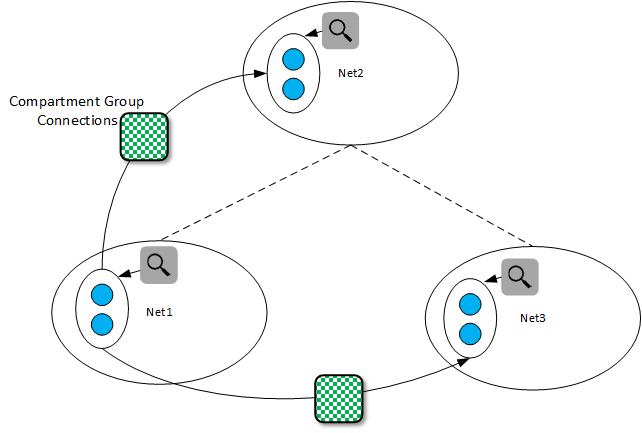

## Create three networks
Three networks net1, net2 and net3 are created, where compartments in net1 are self excited via bias, and net2 and net3 do not have bias. Current, voltage and spike probes for compartments in three networks are defined here.

In [3]:
# create net1 that is driven by bias
net1 = nx.NxNet()
prototype1 = nx.CompartmentPrototype(biasMant=1,
                                     biasExp=6,
                                     vThMant=10,
                                     functionalState=2,
                                     compartmentVoltageDecay=256,
                                     compartmentCurrentDecay=410)
cg1 = net1.createCompartmentGroup(size=2, prototype=prototype1)
# set up net1 probes
(cg1UProbes, cg1VProbes, cg1SProbes) = cg1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                  nx.ProbeParameter.SPIKE])

# create net2 without bias
net2 = nx.NxNet()
prototype2 = nx.CompartmentPrototype(vThMant=10,
                                     compartmentVoltageDecay=256,
                                     compartmentCurrentDecay=410)
cg2 = net2.createCompartmentGroup(size=2, prototype=prototype2)
# set up net2 probes
(cg2UProbes, cg2VProbes, cg2SProbes) = cg2.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                  nx.ProbeParameter.SPIKE])

# create net3 without bias
net3 = nx.NxNet()
prototype3 = nx.CompartmentPrototype(vThMant=10,
                                     compartmentVoltageDecay=256,
                                     compartmentCurrentDecay=410)
cg3 = net3.createCompartmentGroup(size=2, prototype=prototype3)
# set up net3 probes
(cg3UProbes, cg3VProbes, cg3SProbes) = cg3.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                  nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                  nx.ProbeParameter.SPIKE])

uProbes = [cg1UProbes, cg2UProbes, cg3UProbes]
vProbes = [cg1VProbes, cg2VProbes, cg3VProbes]
sProbes = [cg1SProbes, cg2SProbes, cg3SProbes]

## Build connections between networks
In this tutorial, compartment group cg1 connects to compartment groups cg2 and cg3 via excitatory and inhibitory weights respectively. 

In [4]:
connProto1 = nx.ConnectionPrototype()                                  
connGrp1 = cg1.connect(cg2, connProto1,
                       weight=np.array([[4, 0],
                                           [0, 6]]),
                       connectionMask=np.array([[1, 0],
                                                   [0, 1]]))                       

connProto2 = nx.ConnectionPrototype()
connGrp2 = cg1.connect(cg3, connProto2,
                       weight=np.array([[-4, 0],
                                           [0, -6]]),
                       connectionMask=np.array([[1, 0],
                                                   [0, 1]]))

connGrp1WProbe = connGrp1.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])
connGrp2WProbe = connGrp2.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])

## Compose the networks
As shown in the diagram above, the networks tree structure composed of one parent network net2, and two child networks net1 and net2. Child network is added by using addNet from parent network.  

In [5]:
net2.addNet(net1)
net2.addNet(net3)

## Run the networks
By simply running the root network, the entire network tree will run.

In [6]:
net2.run(30)
net2.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (0.01s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.04s)


## Plot the results
Compartment probes information for current, voltage and spike in net1, net2 and net3 are shown here. Net2 gets excitatory connection from net1, one compartment in net2 with weight 4 fires twice, while the other compartment in net2 with weight 6 fires three times. Net3 gets inhibitory connection from net1, and does not fire.

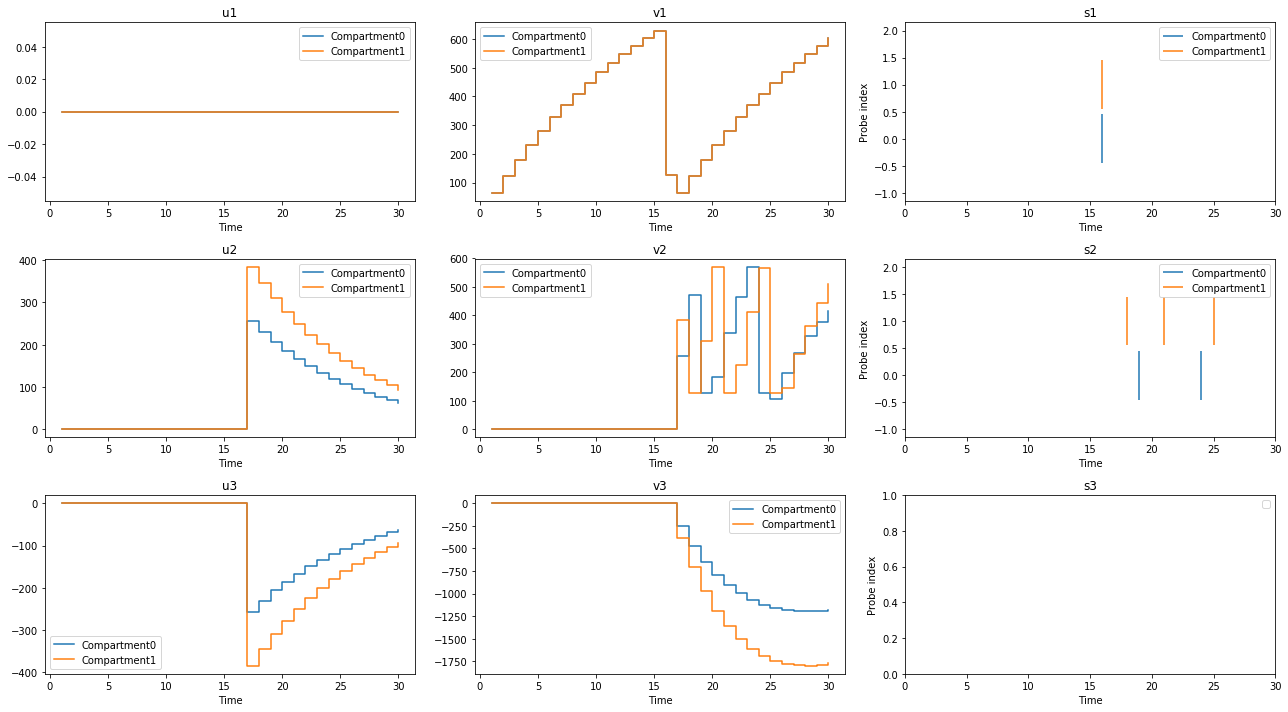

In [7]:
plt.figure(1, figsize=(18,10))
k = 1
numProbes = 3
for j in range(1, numProbes+1):
    ax1 = plt.subplot(numProbes, 3, k)
    uProbes[j-1].plot()
    plt.title('u' + str(j))
    ax1.legend(['Compartment0', 'Compartment1'])
    k += 1
    ax2 = plt.subplot(numProbes, 3, k)
    vh = vProbes[j-1].plot()
    plt.title('v' + str(j))
    ax2.legend(['Compartment0', 'Compartment1'])
    k += 1
    ax3 = plt.subplot(numProbes, 3, k)
    sProbes[j-1].plot(colors=[vh[0].get_color(),vh[1].get_color()])
    ax3.set_xlim(0,30)
    plt.title('s' + str(j))
    ax3.legend(['Compartment0', 'Compartment1'])
    k += 1
    
plt.tight_layout() 
plt.show()

.. code-links:: python clear